<a href="https://colab.research.google.com/github/chaey0/Solar-detection/blob/main/solar_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tarfile

# 파일 경로 입력
tar_file_name = '/content/drive/MyDrive/kasi_solar_event_dataset.tar'

# 압축 해제할 경로 입력
extraction_dir = '/content/dataset'

# 압축 해제
with tarfile.open(tar_file_name, 'r') as tar_ref:
    tar_ref.extractall(extraction_dir)

In [1]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # tqdm 라이브러리 import

class SolarEventDataset(torch.utils.data.Dataset):
    def __init__(self, root, file_names, transforms=None):
        self.root = root
        self.file_names = file_names
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "train", self.file_names[idx] + ".jpg")
        label_path = os.path.join(self.root, "train", self.file_names[idx] + ".xml")

        img = Image.open(img_path).convert("RGB")

        tree = ET.parse(label_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for member in root.findall("object"):
            labels.append(1)  # 모든 객체를 동일한 라벨로 처리
            bndbox = member.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if boxes.numel() == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.file_names)

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# IoU 계산 함수
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union = box1_area + box2_area - intersection

    iou = intersection / union
    return iou

# 전체 데이터셋에서 파일명만 추출
root_dir = '/content/dataset'
all_images = [f[:-4] for f in os.listdir(os.path.join(root_dir, "train")) if f.endswith(".jpg")]

# train과 validation으로 분할 (80:20)
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# 데이터셋과 데이터로더 준비
dataset_train = SolarEventDataset(root=root_dir, file_names=train_files, transforms=get_transform(train=True))
dataset_val = SolarEventDataset(root=root_dir, file_names=val_files, transforms=get_transform(train=False))

data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# 모델 준비 (Faster R-CNN 예시)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
#model.load_state_dict(torch.load('/content/drive/MyDrive/solar/model/fasterrcnn_resnet50_fpn.pth'))

num_classes = 2  # 배경 포함한 클래스 수
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 학습에 사용할 장치 설정 (GPU 사용 가능 여부에 따라 설정)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 옵티마이저 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(data_loader_train, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, targets in progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())

    # validation 성능 평가 (예측 결과를 이용해 추론만 수행)
    model.eval()
    val_iou = []
    with torch.no_grad():
        for images, targets in data_loader_val:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu().numpy()
                true_boxes = targets[i]['boxes'].cpu().numpy()

                if len(true_boxes) == 0:
                    continue

                for pred_box in pred_boxes:
                    iou_scores = [calculate_iou(pred_box, true_box) for true_box in true_boxes]
                    max_iou = max(iou_scores) if iou_scores else 0
                    val_iou.append(max_iou)

    avg_iou = np.mean(val_iou) if val_iou else 0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss/len(data_loader_train):.4f} - Validation IoU: {avg_iou:.4f}")

# 모델 저장
torch.save(model.state_dict(), 'fasterrcnn_solar_event.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]
Epoch 1/10: 100%|██████████| 248/248 [12:54<00:00,  3.12s/it, loss=0.33]


Epoch [1/10] - Train Loss: 0.3957 - Validation IoU: 0.3364


Epoch 2/10: 100%|██████████| 248/248 [12:56<00:00,  3.13s/it, loss=0.314]


Epoch [2/10] - Train Loss: 0.3506 - Validation IoU: 0.3586


Epoch 3/10: 100%|██████████| 248/248 [12:56<00:00,  3.13s/it, loss=0.354]


Epoch [3/10] - Train Loss: 0.3348 - Validation IoU: 0.3976


Epoch 4/10: 100%|██████████| 248/248 [12:55<00:00,  3.13s/it, loss=0.317]


Epoch [4/10] - Train Loss: 0.3196 - Validation IoU: 0.3684


Epoch 5/10: 100%|██████████| 248/248 [12:55<00:00,  3.13s/it, loss=0.28]


Epoch [5/10] - Train Loss: 0.3077 - Validation IoU: 0.4222


Epoch 6/10: 100%|██████████| 248/248 [12:51<00:00,  3.11s/it, loss=0.281]


Epoch [6/10] - Train Loss: 0.3005 - Validation IoU: 0.4340


Epoch 7/10: 100%|██████████| 248/248 [12:47<00:00,  3.09s/it, loss=0.366]


Epoch [7/10] - Train Loss: 0.2925 - Validation IoU: 0.4183


Epoch 8/10: 100%|██████████| 248/248 [12:47<00:00,  3.09s/it, loss=0.214]


Epoch [8/10] - Train Loss: 0.2839 - Validation IoU: 0.4587


Epoch 9/10: 100%|██████████| 248/248 [12:46<00:00,  3.09s/it, loss=0.302]


Epoch [9/10] - Train Loss: 0.2758 - Validation IoU: 0.3785


Epoch 10/10: 100%|██████████| 248/248 [12:46<00:00,  3.09s/it, loss=0.26]


Epoch [10/10] - Train Loss: 0.2735 - Validation IoU: 0.4406


In [2]:
# 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/solar/model/fasterrcnn_solar_event.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


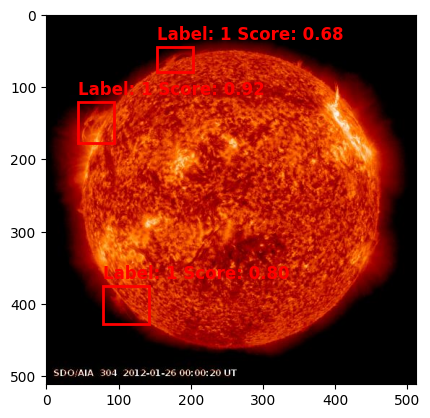

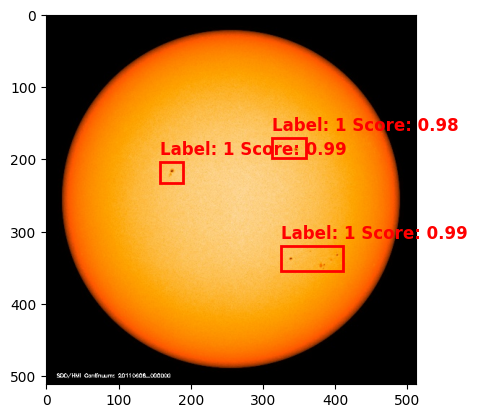

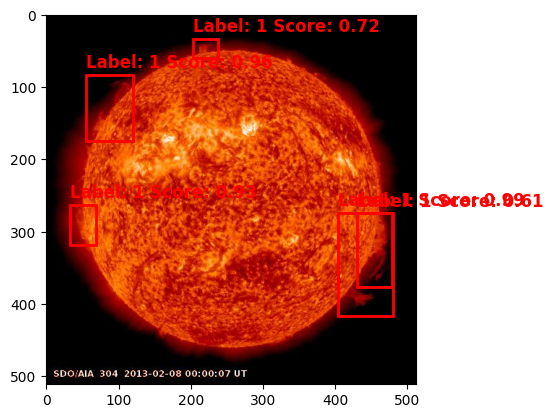

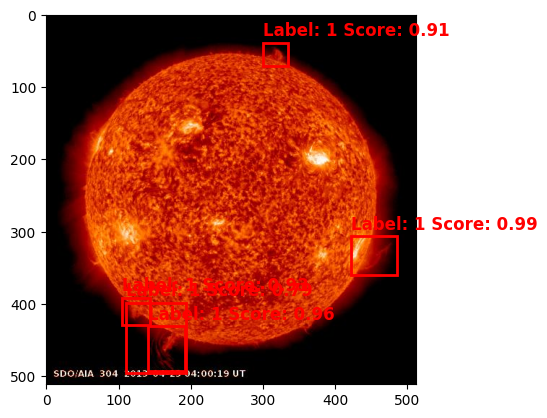

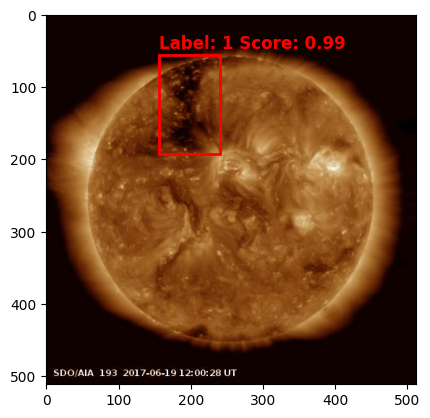

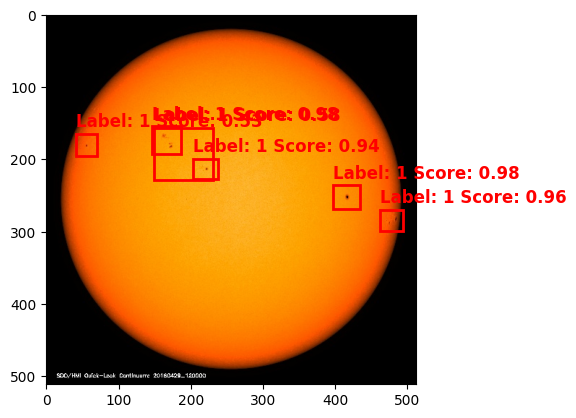

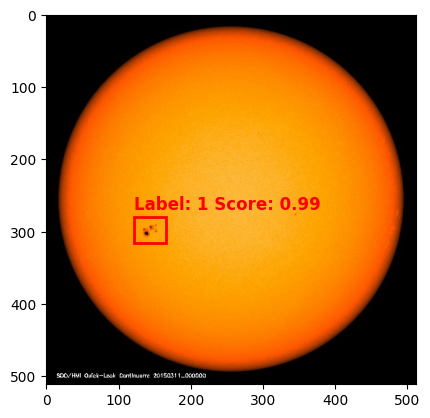

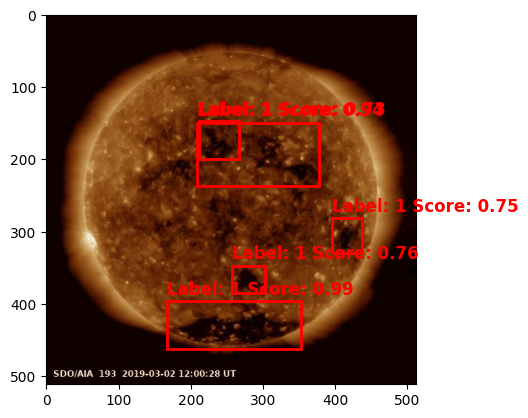

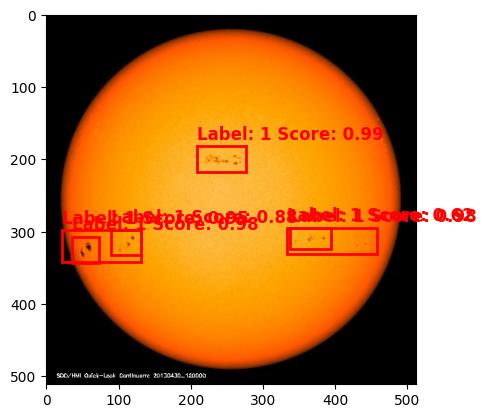

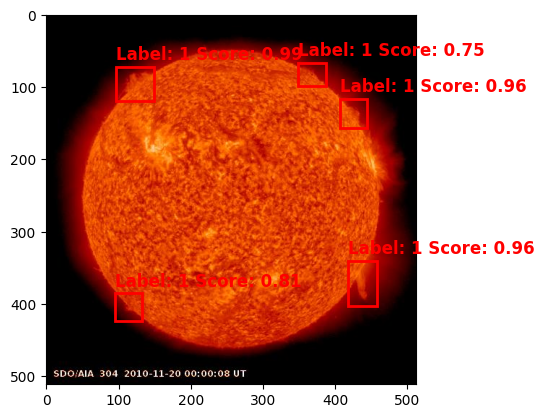

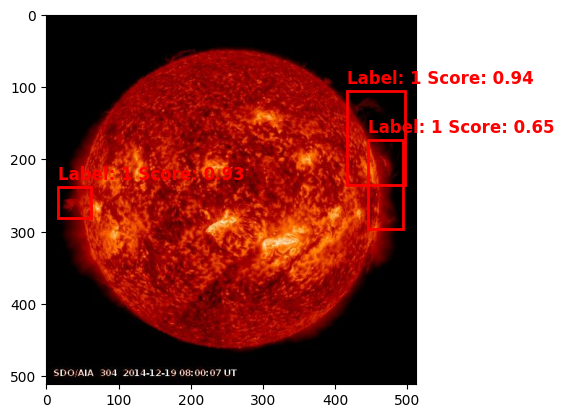

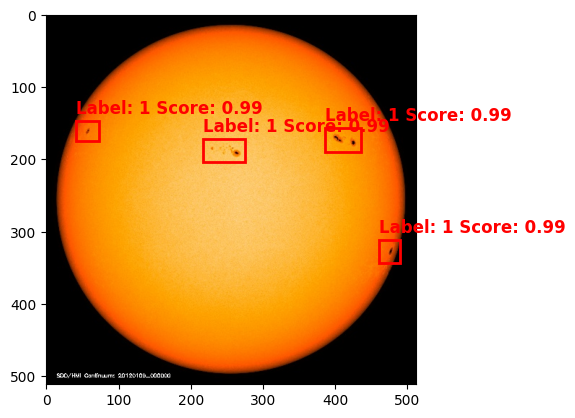

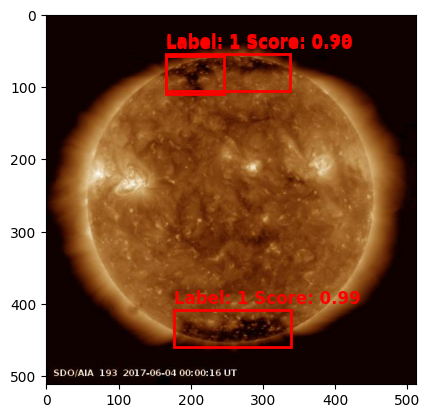

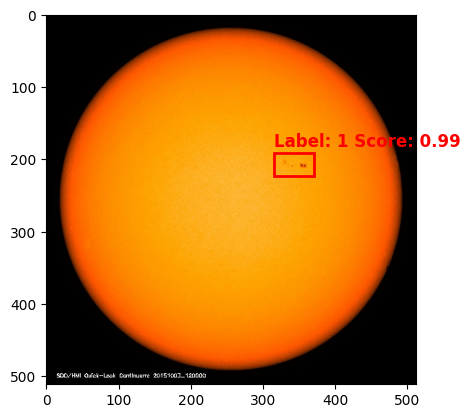

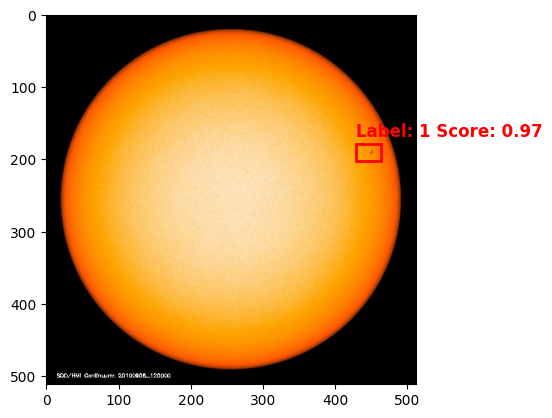

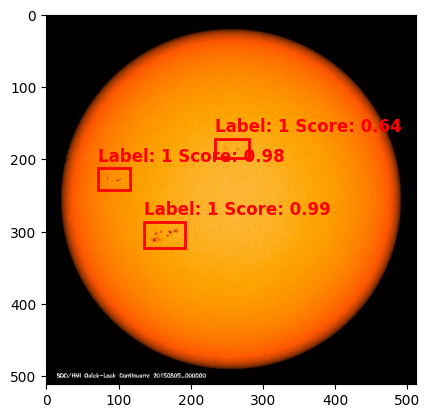

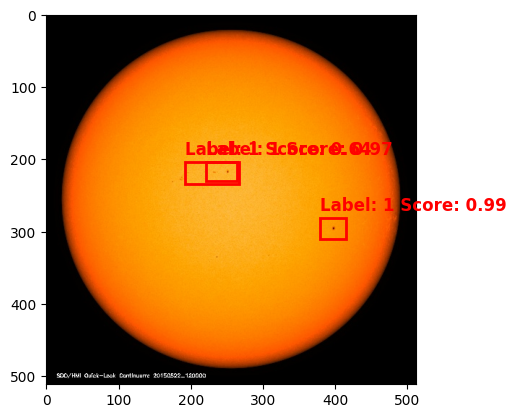

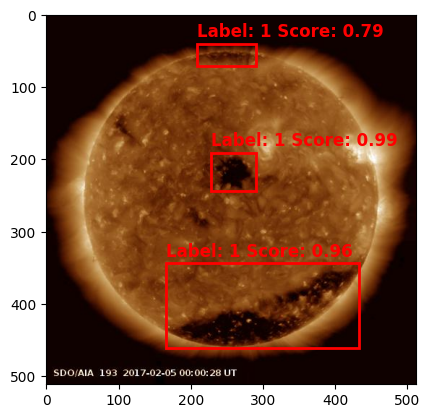

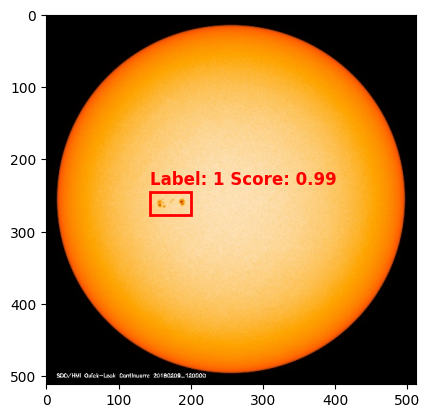

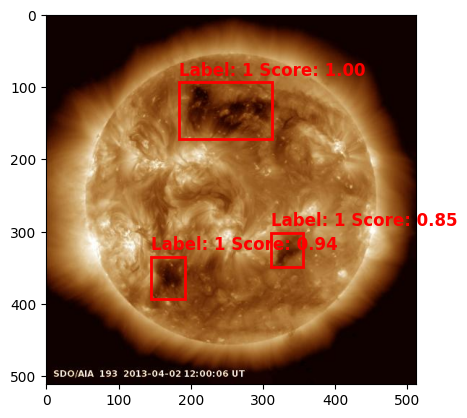

In [7]:
import os
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class SolarEventTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, file_names, transforms=None):
        self.root = root
        self.file_names = file_names
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "test", self.file_names[idx] + ".jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        return img, self.file_names[idx]

    def __len__(self):
        return len(self.file_names)

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# 테스트 데이터셋 준비
test_dir = '/content/dataset'
test_images = [f[:-4] for f in os.listdir(os.path.join(test_dir, "test")) if f.endswith(".jpg")]

# 샘플로 사용할 이미지 인덱스 (예: 5개의 샘플)
sample_indices = [i for i in range(0,20)]
sample_images = [test_images[i] for i in sample_indices]

dataset_test = SolarEventTestDataset(root=test_dir, file_names=sample_images, transforms=get_transform(train=False))
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# 모델 로드
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 배경 포함한 클래스 수
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('fasterrcnn_solar_event.pth'))
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 샘플에 대한 추론 및 시각화
for images, image_ids in data_loader_test:
    images = list(image.to(device) for image in images)

    with torch.no_grad():
        outputs = model(images)

    for i, output in enumerate(outputs):
        pred_boxes = output['boxes'].cpu().numpy()
        pred_labels = output['labels'].cpu().numpy()
        pred_scores = output['scores'].cpu().numpy()

        # 원본 이미지 불러오기 (for visualization)
        img_path = os.path.join(test_dir, "test", image_ids[i] + ".jpg")
        img = Image.open(img_path).convert("RGB")

        # 시각화를 위한 matplotlib 설정
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        for j in range(len(pred_boxes)):
            if pred_scores[j] > 0.5:  # confidence threshold
                box = pred_boxes[j]
                # 사각형 그리기
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                # 레이블 및 스코어 표시
                ax.text(box[0], box[1] - 10, f"Label: {pred_labels[j]} Score: {pred_scores[j]:.2f}", color='red', fontsize=12, weight='bold')

        plt.show()
